In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#load datasets
users = pd.read_csv('takehome_users.csv', encoding='latin1')
engagement = pd.read_csv('takehome_user_engagement.csv')

Exploratory data analysis

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Goal is to identify which factors predict future user adoption with "adopted user" defined as user who has logged into product on three separate days in at least one seven-day period


In [7]:
grouped_engagement = engagement.groupby('user_id').count().sort_values(by = 'visited', ascending = False)
grouped_engagement

,time_stamp,visited
user_id,,
3623,606,606
906,600,600
1811,593,593
7590,590,590
8068,585,585
...,...,...
4699,1,1
4698,1,1
4697,1,1


In [8]:
#check for errors. Want to show any instances where the count of timestamps is 
#different from the number of visits. This would indicate duplicates.
mask = grouped_engagement['time_stamp'] != grouped_engagement['visited']
duplicates = grouped_engagement[mask]
duplicates

,time_stamp,visited
user_id,,


There appear to be no duplicates, with each user's visit mapping to a unique timestamp.

In [9]:
#Returning to the engagement dataset, we see that our time stamp column is an object 
print(engagement['time_stamp'].dtype)

object


In [10]:
#convert to datetime
engagement['time_stamp']= pd.to_datetime(engagement['time_stamp'])
print(engagement['time_stamp'].dtype)

datetime64[ns]


In [11]:
#check total time period covered by engagement df, 
engagement_first = engagement['time_stamp'].min()
engagement_last = engagement['time_stamp'].max()
print("first engagement: ", engagement_first, ", last engagement: ", engagement_last )

first engagement:  2012-05-31 08:20:06 , last engagement:  2014-06-06 14:58:50


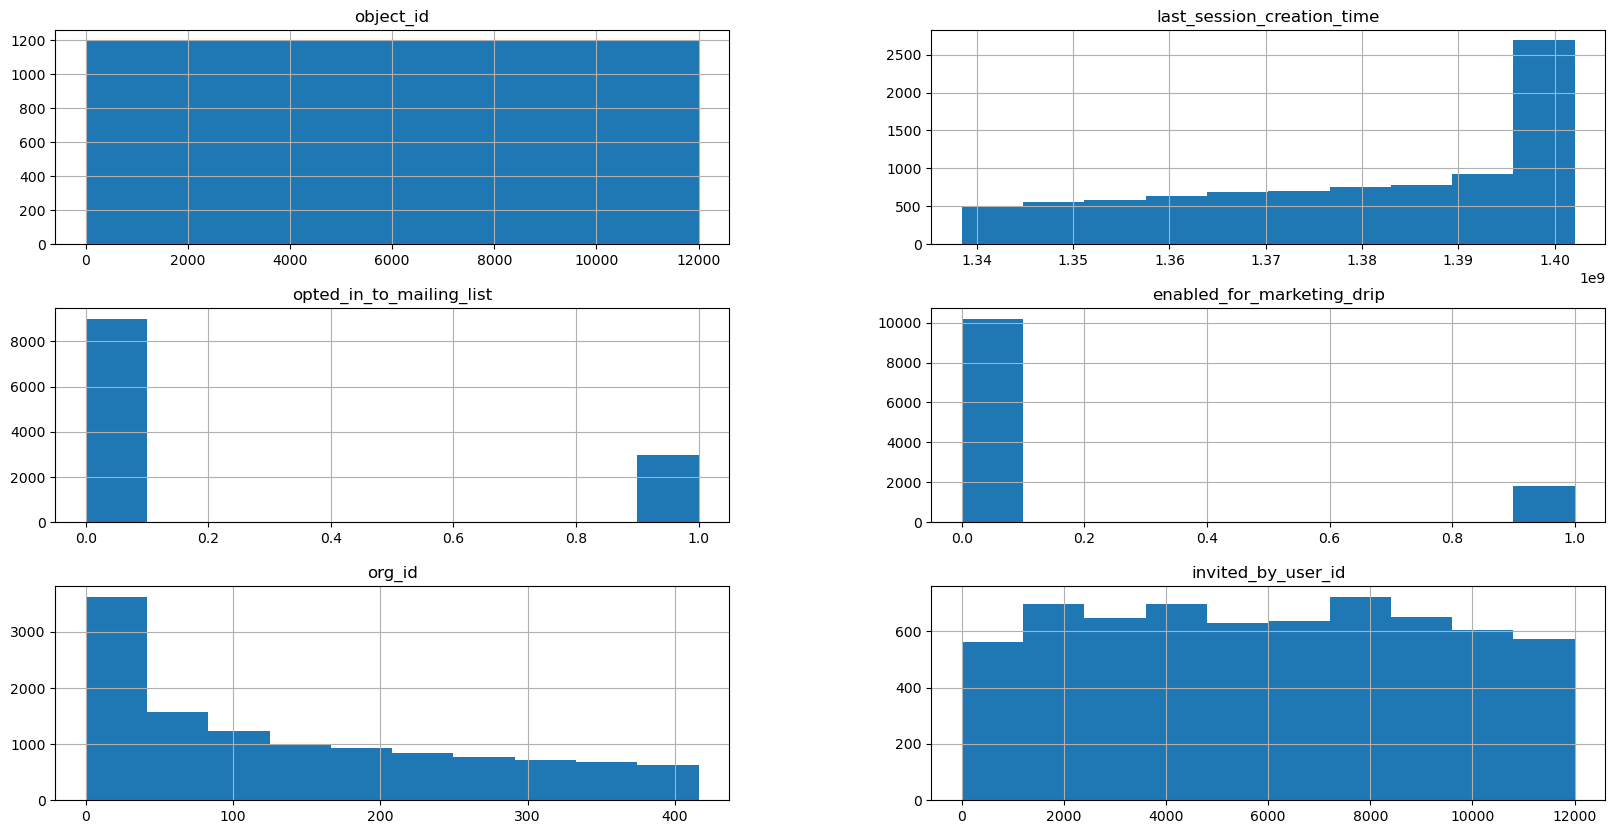

In [12]:
#look at distributions of user info columns
users.hist(figsize = (20,10));

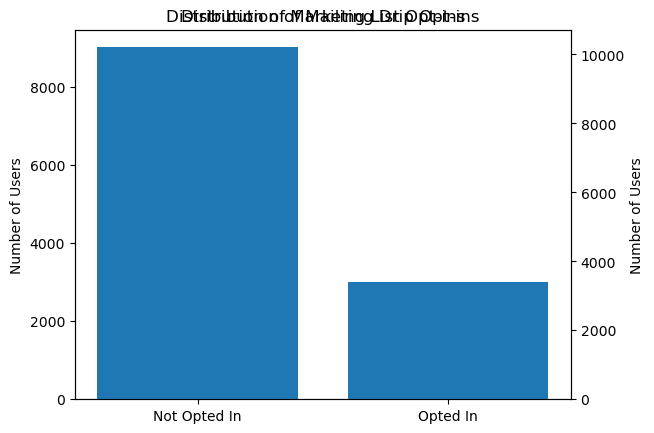

In [13]:
#bar charts showing binary info
mailing_list_value_counts = users['opted_in_to_mailing_list'].value_counts()
enabled_for_marketing_drip_value_counts = users['enabled_for_marketing_drip'].value_counts()

fig, ax1 = plt.subplots()
ax1.bar(mailing_list_value_counts.index, mailing_list_value_counts.values)
ax1.set_xticks([0, 1], ['Not Opted In', 'Opted In'])
ax1.set_ylabel('Number of Users')
ax1.set_title('Distribution of Mailing List Opt-ins')

ax2 = ax1.twinx()
ax2.bar(enabled_for_marketing_drip_value_counts.index, enabled_for_marketing_drip_value_counts.values)
ax2.set_xticks([0, 1], ['Not Opted In', 'Opted In'])
ax2.set_ylabel('Number of Users')
ax2.set_title('Distribution of Marketing Drip Opt-ins')
plt.show()

plan: use rolling window to find list of users who meet "adopter" criteria. Use pairplot to show correlation with each column

In [14]:
#set index
engagement.set_index('time_stamp', drop = True, inplace = True)
engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [20]:
#sort values
engagement.sort_values(by = ['user_id','time_stamp'], inplace = True)
#engagement.head(30)

In [52]:
# Check the rolling sum calculation and structure before filtering
check_rolling = engagement.groupby('user_id').rolling(window='7D').visited.sum()
print(check_rolling.head(20))

user_id  time_stamp         
1        2014-04-22 03:53:30    1.0
2        2013-11-15 03:45:04    1.0
         2013-11-29 03:45:04    1.0
         2013-12-09 03:45:04    1.0
         2013-12-25 03:45:04    1.0
         2013-12-31 03:45:04    2.0
         2014-01-08 03:45:04    1.0
         2014-02-03 03:45:04    1.0
         2014-02-08 03:45:04    2.0
         2014-02-09 03:45:04    3.0
         2014-02-13 03:45:04    3.0
         2014-02-16 03:45:04    2.0
         2014-03-09 03:45:04    1.0
         2014-03-13 03:45:04    2.0
         2014-03-31 03:45:04    1.0
3        2013-03-19 23:14:52    1.0
4        2013-05-22 08:09:28    1.0
5        2013-01-22 10:14:20    1.0
6        2013-12-19 03:37:06    1.0
7        2012-12-20 13:24:32    1.0
Name: visited, dtype: float64


In [62]:
# Apply filter for adopted criteria
adopted = check_rolling[check_rolling >= 3]
adopted

user_id  time_stamp         
2        2014-02-09 03:45:04    3.0
         2014-02-13 03:45:04    3.0
10       2013-02-19 22:08:03    3.0
         2013-03-02 22:08:03    3.0
         2013-03-05 22:08:03    3.0
                               ... 
11988    2014-05-23 11:04:47    6.0
         2014-05-24 11:04:47    6.0
         2014-05-26 11:04:47    5.0
         2014-05-27 11:04:47    5.0
         2014-06-01 11:04:47    3.0
Name: visited, Length: 160522, dtype: float64

In [65]:
# Reset index to make 'user_id' and 'time_stamp' regular columns again
adopted_users = adopted.reset_index()
adopted_users

,user_id,time_stamp,visited
0,2,2014-02-09 03:45:04,3.0
1,2,2014-02-13 03:45:04,3.0
2,10,2013-02-19 22:08:03,3.0
3,10,2013-03-02 22:08:03,3.0
4,10,2013-03-05 22:08:03,3.0
...,...,...,...
160517,11988,2014-05-23 11:04:47,6.0
160518,11988,2014-05-24 11:04:47,6.0
160519,11988,2014-05-26 11:04:47,5.0
160520,11988,2014-05-27 11:04:47,5.0


In [68]:
#Group by 'user_id' and get the maximum 'visited' count
adopted_users_max_visits = adopted_users.groupby('user_id').visited.max().reset_index()
adopted_users_max_visits

,user_id,visited
0,2,3.0
1,10,7.0
2,20,3.0
3,33,3.0
4,42,7.0
...,...,...
1597,11965,4.0
1598,11967,7.0
1599,11969,7.0
1600,11975,7.0


In [79]:
adopted_users_max_visits.sort_values(by='user_id', inplace=True)
print(adopted_users_max_visits['user_id'])

0           2
1          10
2          20
3          33
4          42
        ...  
1597    11965
1598    11967
1599    11969
1600    11975
1601    11988
Name: user_id, Length: 1602, dtype: int64


Now we've identified the user id numbers that fit our adoption criteria. Next we will merge these results with the users df
to identify trends in user details and whether or not they adopt

In [87]:
#Initialize a new column in the users df set to 0
users['is_adopter'] = 0
print(users.head())
#Create new df from adopters with user id
#use [[]] so create df and not series
adopters = adopted_users_max_visits[['user_id']]
#add new column set to 1
adopters['is_adopter'] = 1
print(adopters.head())

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

In [88]:
#merge users and adopters dfs
users.merge(adopters, left_on = 'object_id', right_on = 'user_id', how = 'left')

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopter_x,user_id,is_adopter_y
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,NaN,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0,2.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,NaN,NaN
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,NaN,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0,NaN,NaN
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0,NaN,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0,NaN,NaN
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0,NaN,NaN


In [93]:
#fill NaN values with 0
users['is_adopter'].fillna(0, inplace = True)
users.head(15)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopter
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,0
